# UNav Localization Pipeline Visualization

This notebook demonstrates and visualizes the end-to-end localization pipeline for the UNav system, from feature extraction to geometric verification and final pose refinement. It is intended for inspection, debugging, and research analysis in visual indoor localization.

## 1. Define Data Paths and Experiment Parameters

Set up all root directories and configuration parameters required for this localization session, including place/building/floor identifiers and feature models.

In [1]:
DATA_FINAL_ROOT = "/mnt/data/UNav-IO/data"
DATA_TEMP_ROOT = "/mnt/data/UNav-IO/temp"
FEATURE_MODEL = "DinoV2Salad"
LOCAL_FEATURE_MODEL = "superpoint+lightglue"

PLACES = {
    "New_York_City": {
        "LightHouse": ["3_floor", "4_floor", "6_floor"]
    },
    "fsfasdfa":{
        "asdfa": ['df','fd'],
        "ags": ['gs','gd']
    }
}

## 2. Import Libraries and UNav Modules

Import all required standard libraries, configuration utilities, and matplotlib for visualization.

In [2]:
import cv2
from unav.config import UNavConfig
import matplotlib.pyplot as plt

## 3. Build Configuration and Initialize the Localizer

Create the unified configuration object and instantiate the `UNavLocalizer`. Load all maps and features for the configured floors. This step may take several seconds to minutes depending on the dataset size.

In [3]:
config = UNavConfig(
    data_final_root=DATA_FINAL_ROOT,
    places=PLACES,
    global_descriptor_model=FEATURE_MODEL,
    local_feature_model=LOCAL_FEATURE_MODEL
)
localizor_config = config.localizer_config

from unav.localizer.localizer import UNavLocalizer

localizer = UNavLocalizer(localizor_config)
localizer.load_maps_and_features()

Seed set to: 42 (type: <class 'int'>)


/home/unav/Desktop/unav/unav/core/third_party/LightGlue/lightglue/lightglue.py:15: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/unav/Desktop/unav/unav/core/third_party/SuperPoint_SuperGlue/extractors/SuperGluePretrainedNetwork/models/superpoint.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are expli

[INFO] Initializing models: Local -> superpoint+lightglue | Global -> DinoV2Salad
Loaded SuperPoint model


Using cache found in /home/unav/.cache/torch/hub/facebookresearch_dinov2_main
/home/unav/Desktop/unav/unav/core/third_party/salad/feature_extract.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Loaded model from /mnt/data/UNav-IO/data/parameters/DinoV2Salad/ckpts/dino_salad.ckpt successfully!
[✓] Loaded COLMAP model for ('New_York_City', 'LightHouse', '3_floor'): 4752 frames
[✓] Loaded global features for ('New_York_City', 'LightHouse', '3_floor'): 4752 images
[✓] Loaded transform matrix for ('New_York_City', 'LightHouse', '3_floor'): shape=(2, 4)
[✓] Loaded COLMAP model for ('New_York_City', 'LightHouse', '4_floor'): 5310 frames
[✓] Loaded global features for ('New_York_City', 'LightHouse', '4_floor'): 5310 images
[✓] Loaded transform matrix for ('New_York_City', 'LightHouse', '4_floor'): shape=(2, 4)
[✓] Loaded COLMAP model for ('New_York_City', 'LightHouse', '6_floor'): 6318 frames
[✓] Loaded global features for ('New_York_City', 'LightHouse', '6_floor'): 6318 images
[✓] Loaded transform matrix for ('New_York_City', 'LightHouse', '6_floor'): shape=(2, 4)
[WARNING] Could not load COLMAP model for ('fsfasdfa', 'asdfa', 'df'): [Errno 2] No such file or directory: '/mnt/data/U

## 4. Load and Display Query Image

Read a test image for localization and display it for reference.

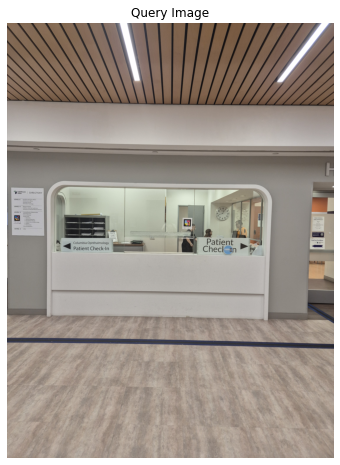

In [11]:
test_image_path = "/mnt/data/UNav-IO/test/photos/LightHouse/3-1.jpg"
img = cv2.imread(test_image_path)
if img is None:
    raise FileNotFoundError(f"Cannot load test image: {test_image_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.title("Query Image")
plt.show()

## 5. Extract Global and Local Features from the Query Image

Compute the global descriptor and local keypoints for the query image. Visualize detected keypoints to inspect coverage and score distribution.

Global feature shape: (8448,)
Local keypoints: (3449, 2)
Keypoint score range: 0.0050 ~ 0.7418


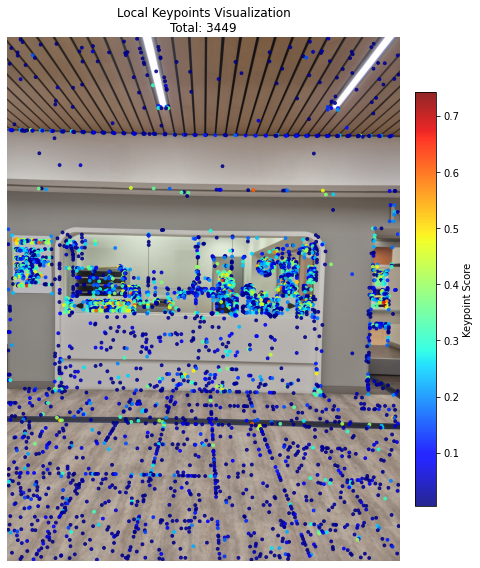

In [12]:
from unav.visualization_tools.localization_visualization_tools import visualize_local_keypoints_on_image

global_feat, local_feat_dict = localizer.extract_query_features(img)
print("Global feature shape:", global_feat.shape)
print("Local keypoints:", local_feat_dict['keypoints'].shape)
print("Keypoint score range: {:.4f} ~ {:.4f}".format(
    local_feat_dict['scores'].min(), local_feat_dict['scores'].max()))

visualize_local_keypoints_on_image(
    img, 
    local_feat_dict['keypoints'], 
    local_feat_dict['scores'],
    figsize=(8, 8)
)

## 6. Visual Place Recognition (VPR): Retrieve Top-K Candidates

Use the global descriptor to retrieve the top-K most similar database images (across all mapped floors). Visualize candidate images for inspection.

Top candidates: [(('New_York_City', 'LightHouse', '3_floor'), '000255_pitch00_yaw14.png', 0.5014914870262146), (('New_York_City', 'LightHouse', '3_floor'), '000256_pitch00_yaw15.png', 0.47655388712882996), (('New_York_City', 'LightHouse', '3_floor'), '000256_pitch00_yaw14.png', 0.47365519404411316), (('New_York_City', 'LightHouse', '3_floor'), '000257_pitch00_yaw15.png', 0.47214698791503906), (('New_York_City', 'LightHouse', '3_floor'), '000257_pitch00_yaw14.png', 0.4696875810623169), (('New_York_City', 'LightHouse', '3_floor'), '000263_pitch00_yaw11.png', 0.46779799461364746), (('New_York_City', 'LightHouse', '3_floor'), '000254_pitch00_yaw13.png', 0.4626215994358063), (('New_York_City', 'LightHouse', '3_floor'), '000258_pitch00_yaw14.png', 0.45872384309768677), (('New_York_City', 'LightHouse', '3_floor'), '000260_pitch00_yaw09.png', 0.4529131054878235), (('New_York_City', 'LightHouse', '3_floor'), '000003_pitch00_yaw00.png', 0.4472832679748535), (('New_York_City', 'LightHouse', '3_fl

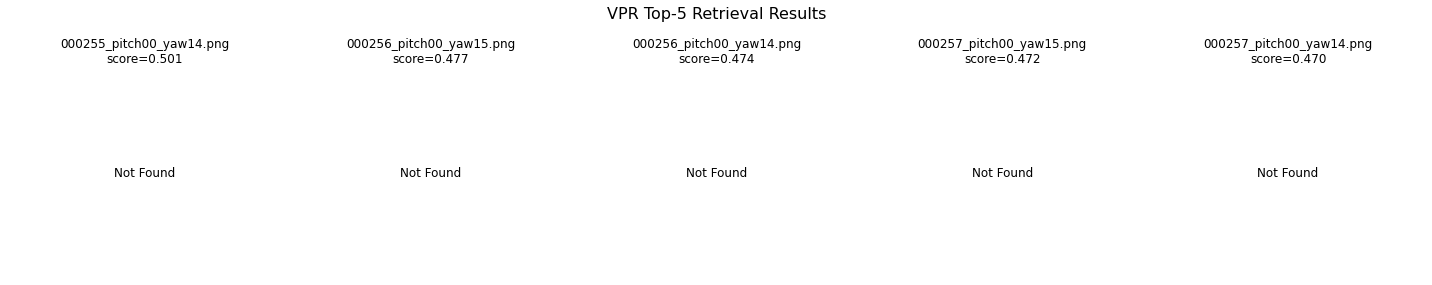

In [13]:
from unav.visualization_tools.localization_visualization_tools import plot_topk_vpr_candidates

top_candidates = localizer.vpr_retrieve(global_feat, top_k=50)
print("Top candidates:", top_candidates)

plot_topk_vpr_candidates(top_candidates, k=5, root_dir=DATA_TEMP_ROOT)

## 7. Load Candidate Reference Data and Visualize on Floorplans

For the VPR top-K, load their COLMAP frame information and local features. Visualize the candidate positions and headings on the registered floorplans.

Candidates per floorplan:
  ('New_York_City', 'LightHouse', '3_floor'): 46 candidates
  ('New_York_City', 'LightHouse', '6_floor'): 4 candidates


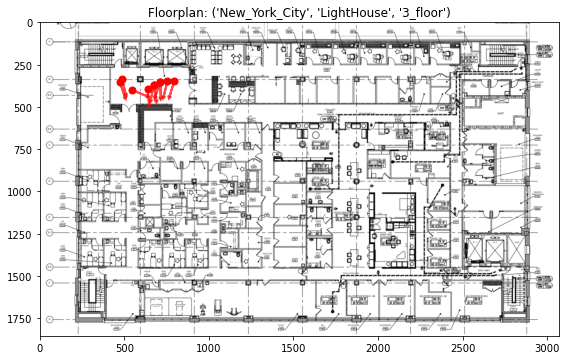

In [14]:
from unav.visualization_tools.localization_visualization_tools import visualize_candidates_on_floorplans_with_heading
from collections import Counter

candidates_data = localizer.get_candidates_data(top_candidates)
mapkey_counter = Counter([map_key for map_key, _, _ in top_candidates])
print("Candidates per floorplan:")
for map_key, count in mapkey_counter.items():
    print(f"  {map_key}: {count} candidates")

visualize_candidates_on_floorplans_with_heading(
    top_candidates=top_candidates,
    localizer=localizer,
    candidates_data=candidates_data,
    k=10,
    root_dir=DATA_FINAL_ROOT
)

## 8. Batch Local Matching and RANSAC Verification

Run local feature matching and geometric verification (RANSAC) for all candidates. Visualize matched keypoints between query and references to assess match quality.

In [15]:
from unav.visualization_tools.localization_visualization_tools import visualize_query_candidate_matches
from unav.localizer.tools.io import load_local_features

best_map_key, pnp_pairs, results = localizer.batch_local_matching_and_ransac(local_feat_dict, candidates_data)
print("Best map key:", best_map_key)
print("Number of candidates after local matching:", len(results))
print("PnP pairs 2D shape:", pnp_pairs['image_points'].shape, "3D shape:", pnp_pairs['object_points'].shape)

# Preload all candidate keypoints for visualization
all_candidates_kpts = {}
for res in results:
    map_key = res['map_key']
    ref_name = res['ref_image_name']
    if map_key not in all_candidates_kpts:
        all_candidates_kpts[map_key] = {}
    if ref_name not in all_candidates_kpts[map_key]:
        h5_path = localizer.local_feat_paths[map_key]
        feats = load_local_features(h5_path, [ref_name])
        all_candidates_kpts[map_key][ref_name] = feats[ref_name]['keypoints']

visualize_query_candidate_matches(
    query_img=img,
    query_kpts=local_feat_dict['keypoints'],
    results=results,
    all_candidates_kpts=all_candidates_kpts,
    root_dir=DATA_TEMP_ROOT,
    num_pairs=3,
    figsize=(12,5)
)

Best map key: ('New_York_City', 'LightHouse', '3_floor')
Number of candidates after local matching: 14
PnP pairs 2D shape: (1695, 2) 3D shape: (1695, 3)
[WARNING] Candidate image not found: /mnt/data/UNav-IO/temp/New_York_City/LightHouse/3_floor/perspectives/000255_pitch00_yaw15.png
[WARNING] Candidate image not found: /mnt/data/UNav-IO/temp/New_York_City/LightHouse/3_floor/perspectives/000256_pitch00_yaw15.png
[WARNING] Candidate image not found: /mnt/data/UNav-IO/temp/New_York_City/LightHouse/3_floor/perspectives/000255_pitch00_yaw14.png


## 9. Visualize 2D-3D Crosslink on Floorplan

Project the inlier 2D-3D correspondences onto the registered floorplan and visualize the spatial relationship. This provides geometric intuition about the localization outcome.

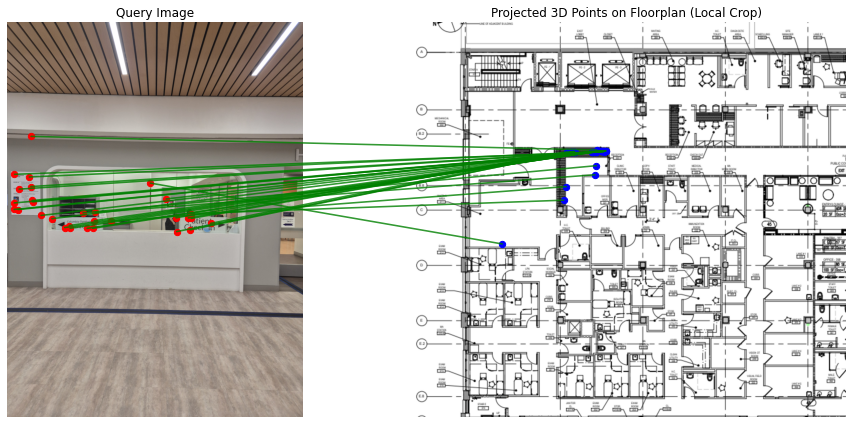

In [16]:
import os
import cv2
from unav.visualization_tools.localization_visualization_tools import visualize_2d_3d_crosslink

floorplan_path = os.path.join(
    DATA_FINAL_ROOT, *best_map_key, "floorplan.png"
)
floorplan_img = cv2.imread(floorplan_path)
if floorplan_img is not None and floorplan_img.ndim == 3:
    floorplan_img = cv2.cvtColor(floorplan_img, cv2.COLOR_BGR2RGB)

transform_matrix = localizer.transform_matrices[best_map_key]

visualize_2d_3d_crosslink(
    query_img=img,
    image_points=pnp_pairs['image_points'],
    object_points=pnp_pairs['object_points'],
    transform_matrix=transform_matrix,
    floorplan_img=floorplan_img,
    num_matches=30,
    crop_size=2000
)

## 10. Multi-frame Pose Refinement

Apply sliding-window multi-frame pose refinement using the current frame and history (simulated here). Print the refined pose estimate.

In [17]:
# Prepare refinement queue (normally accumulated over video)
refinement_queue = {best_map_key: {"pairs": [], "initial_poses": [], "pps": []}}
refine_result = localizer.multi_frame_pose_refine(
    pnp_pairs, img.shape, refinement_queue[best_map_key]
)
print("Refinement result:", refine_result)

Refinement result: {'success': True, 'qvec': array([ 0.98555407, -0.00918393, -0.16548533,  0.03483453]), 'tvec': array([ 6.79174163, -1.07865196, -5.87653385]), 'n_frames': 1, 'new_refinement_queue': {'pairs': [{'image_points': array([[  37., 1512.],
       [  73., 1540.],
       [  74., 1573.],
       ...,
       [ 434., 2102.],
       [1906., 2104.],
       [1717., 2121.]], dtype=float32), 'object_points': array([[-8.70841599,  0.0173183 ,  9.18750094],
       [-8.60570572,  0.10081697,  9.15419993],
       [-8.59257459,  0.21361913,  9.16664286],
       ...,
       [-7.49984132,  1.94550964,  8.92938921],
       [-3.37576151,  1.56697747,  7.52854271],
       [-3.93426052,  1.68755593,  7.71649555]])}], 'initial_poses': [[q:   0.966531    0.24833 -0.0595986 -0.0244637, t: 5.59323 2.26231       0 ]
], 'pps': [array([1492.29267316, 2006.75899695])]}}


## 11. Project Final Camera Pose onto Floorplan

Transform the estimated pose into floorplan coordinates and visualize it. This provides the final spatial output used for navigation.

Floorplan Pose (x, y, angle): {'xy': array([658.89685115, 498.01405747]), 'ang': 90.21002199284992}


/home/unav/Desktop/unav/unav/visualization_tools/localization_visualization_tools.py:325: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(cam_xy[0], cam_xy[1], marker, color=color, markersize=14)


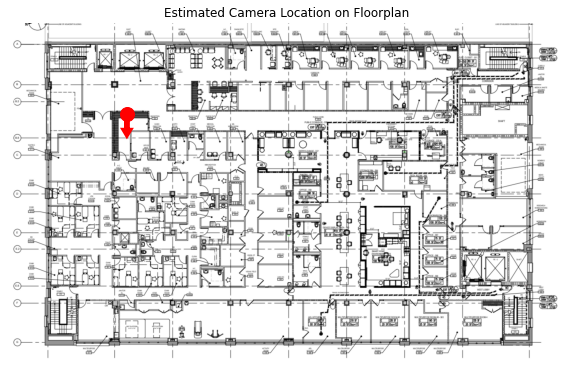

In [18]:
from unav.visualization_tools.localization_visualization_tools import plot_camera_on_floorplan

transform_matrix = localizer.transform_matrices.get(best_map_key)
if transform_matrix is not None and refine_result["success"]:
    colmap_pose = {"qvec": refine_result.get("qvec"), "tvec": refine_result.get("tvec")}
    floorplan_pose = localizer.transform_pose_to_floorplan(
        colmap_pose["qvec"], colmap_pose["tvec"], transform_matrix
    )
    print("Floorplan Pose (x, y, angle):", floorplan_pose)
else:
    print("Floorplan transform not available.")

if floorplan_pose is not None and floorplan_pose["xy"] is not None:
    cam_xy = tuple(floorplan_pose["xy"])
    cam_angle = floorplan_pose["ang"]
    plot_camera_on_floorplan(
        floorplan_img,
        cam_xy,
        cam_angle,
        marker='ro',
        color='red'
    )
else:
    print("Floorplan transform not available or failed.")